In [1]:
!pip install ultralytics opencv-python-headless


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 12.6 MB/s eta 0:00:00 0:00:01


In [2]:
import torch
import torch.utils.checkpoint
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt


# Class Distribution

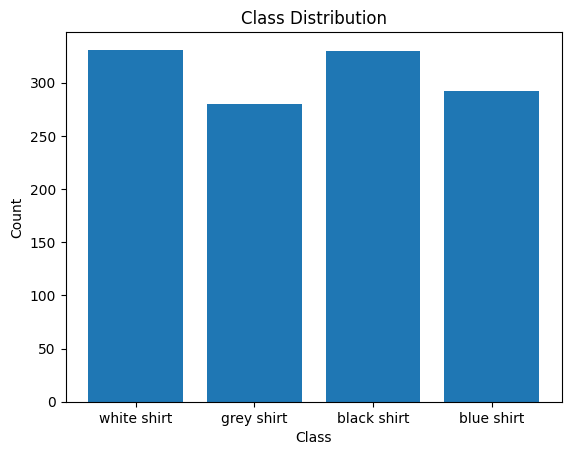

In [3]:
from collections import Counter

# Define the classes
classes = ['black shirt', 'blue shirt', 'grey shirt', 'white shirt']
dataset_path = '/kaggle/input/yolo-dataset-f/Annotated-Images-7'
label_dirs = ['train/labels', 'valid/labels', 'test/labels']

class_counts = Counter()
for label_dir in label_dirs:
    label_path = os.path.join(dataset_path, label_dir)
    for label_file in os.listdir(label_path):
        with open(os.path.join(label_path, label_file), 'r') as f:
            for line in f.readlines():
                class_id = int(line.strip().split()[0])
                class_counts[classes[class_id]] += 1

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

# Basic Data Overview
**Description**:
* This includes loading the dataset and looking at its structure, such as the number of samples, number of features, and basic statistics.
* For an image dataset, you can display some sample images along with their labels.

Total images: 878


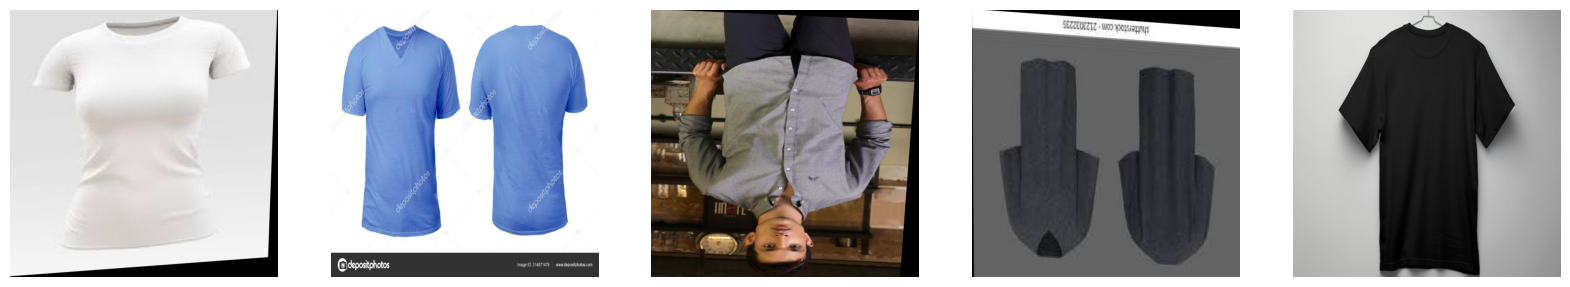

In [4]:
dataset_path_train ='/kaggle/input/yolo-dataset-f/Annotated-Images-7/train/images'

# List files in the directory
image_files = os.listdir(dataset_path_train)
print(f'Total images: {len(image_files)}')

# Display a few sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, img_file in enumerate(image_files[:5]):
    img_path = os.path.join(dataset_path_train, img_file)
    img = cv2.imread(img_path)
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
plt.show()

# Class Distribution of Training set
**Description:**
* Analyze the distribution of classes in your dataset to check for class imbalance.
* This is crucial for classification tasks to ensure your model isn't biased towards a majority class.

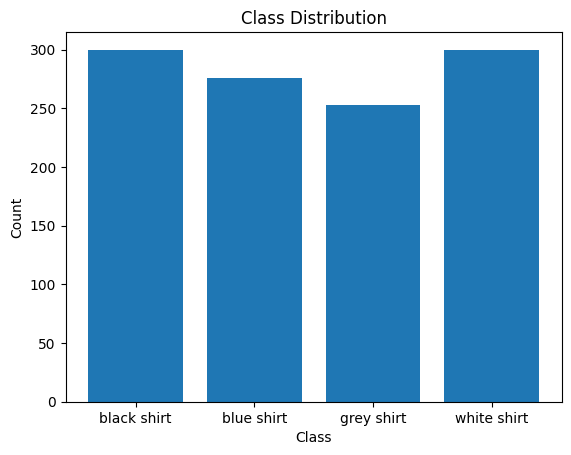

In [5]:
# Path to labels
labels_path = '/kaggle/input/yolo-dataset-f/Annotated-Images-7/train/labels'

# Initialize a dictionary to store class counts
class_counts = {'black shirt': 0, 'blue shirt': 0, 'grey shirt': 0, 'white shirt': 0}

# Iterate over label files and count class occurrences
for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            if class_id == 0:
                class_counts['black shirt'] += 1
            elif class_id == 1:
                class_counts['blue shirt'] += 1
            elif class_id == 2:
                class_counts['grey shirt'] += 1
            elif class_id == 3:
                class_counts['white shirt'] += 1

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [6]:
print(sum(class_counts.values()))

1129


In [7]:
print(class_counts["black shirt"])
print(class_counts["blue shirt"])
print(class_counts["grey shirt"])
print(class_counts["white shirt"])

300
276
253
300


# Image Dimension Analysis
Description:
* Check the dimensions of the images to ensure consistency.
* This can help identify if any images need resizing or preprocessing.

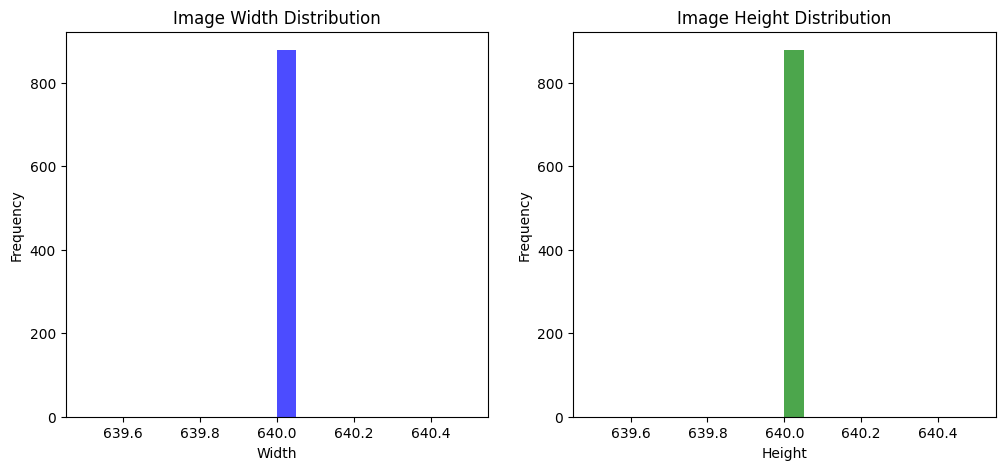

In [8]:
# Initialize lists to store dimensions
widths = []
heights = []

# Iterate over image files and record dimensions
for img_file in os.listdir(dataset_path_train):
    img_path = os.path.join(dataset_path_train, img_file)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)

# Plot histograms of image dimensions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='blue', alpha=0.7)
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='green', alpha=0.7)
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Image Height Distribution')

plt.show()

# Fine Tuning

In [9]:
model = YOLO('yolov8s.pt')  # Download the pre-trained YOLOv8 model

# Define the paths
dataset_path = '/kaggle/input/yolo-dataset-f/Annotated-Images-7'
data_yaml_path = os.path.join(dataset_path, 'data.yaml')
working_directory = '/kaggle/working'

100%|██████████| 21.5M/21.5M [00:00<00:00, 56.6MB/s]


In [10]:
import shutil
# Copy data.yaml to a writable directory
shutil.copy(data_yaml_path, working_directory)
data_yaml_path_writable = os.path.join(working_directory, 'data.yaml')

# Ensure your data.yaml has the correct paths
data_yaml_content = f"""
train: {dataset_path}/train/images
val: {dataset_path}/valid/images
test: {dataset_path}/test/images

nc: 4  # number of classes
names: ['black shirt', 'blue shirt', 'grey shirt', 'white shirt']
"""

In [11]:
# Write the correct paths to data.yaml in the writable directory
with open(data_yaml_path_writable, 'w') as f:
    f.write(data_yaml_content)


In [12]:
# Training configuration
train_cfg = {
    'imgsz': 640,  # Image size
    'batch': 16,   # Batch size
    'epochs': 30,  # Number of epochs
    'data': data_yaml_path_writable,
}

In [13]:
model.train(data=train_cfg['data'], imgsz=train_cfg['imgsz'], epochs=train_cfg['epochs'], batch=train_cfg['batch'])


Ultralytics YOLOv8.2.69 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 4.62MB/s]
2024-07-30 06:53:15,585	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-30 06:53:16,706	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 24.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/yolo-dataset-f/Annotated-Images-7/train/labels... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:00<00:00, 1063.79it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/yolo-dataset-f/Annotated-Images-7/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/yolo-dataset-f/Annotated-Images-7/valid/labels... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 566.68it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/yolo-dataset-f/Annotated-Images-7/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.68G       1.32      2.144      1.628         47        640: 100%|██████████| 55/55 [00:18<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         60         77      0.868      0.495      0.688       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.61G      1.202       1.26      1.468         42        640: 100%|██████████| 55/55 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         60         77      0.664      0.556      0.587      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.61G      1.178      1.165       1.46         42        640: 100%|██████████| 55/55 [00:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         60         77      0.517       0.51      0.277      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.61G      1.154      1.068      1.432         35        640: 100%|██████████| 55/55 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

                   all         60         77      0.644      0.479      0.535      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.58G      1.135      1.013      1.414         42        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         60         77      0.636      0.703      0.724      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       4.6G      1.133      1.006      1.421         39        640: 100%|██████████| 55/55 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         60         77      0.746       0.75      0.801      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.59G      1.121     0.9842      1.396         44        640: 100%|██████████| 55/55 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         60         77      0.822      0.777      0.885      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.61G      1.066     0.8726      1.356         46        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         60         77      0.694       0.81      0.777        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.58G      1.088      0.899      1.377         38        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         60         77      0.885      0.859      0.926      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.59G      1.046     0.8616      1.348         40        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         60         77      0.839      0.916      0.914       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.59G      1.026     0.8087      1.337         39        640: 100%|██████████| 55/55 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         60         77      0.839      0.878       0.87      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.61G      1.014     0.7973       1.34         43        640: 100%|██████████| 55/55 [00:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

                   all         60         77      0.774      0.844      0.907      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.57G     0.9941      0.768       1.32         39        640: 100%|██████████| 55/55 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         60         77      0.913      0.879      0.942      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.59G      1.019     0.7329      1.331         40        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         60         77       0.85      0.925      0.938      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.58G     0.9859      0.763      1.296         42        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         60         77      0.837      0.806      0.879      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       4.6G     0.9646     0.7167      1.297         40        640: 100%|██████████| 55/55 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         60         77      0.944      0.902      0.953      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.58G     0.9339     0.6949      1.272         48        640: 100%|██████████| 55/55 [00:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         60         77      0.904      0.934      0.969      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.61G     0.9359     0.6749      1.269         44        640: 100%|██████████| 55/55 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         60         77      0.858      0.906      0.905      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       4.6G     0.9217     0.6301      1.259         47        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         60         77      0.936      0.883      0.955      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.62G     0.8972     0.6276      1.243         46        640: 100%|██████████| 55/55 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

                   all         60         77      0.929      0.909      0.954      0.699


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.57G     0.8501     0.6054      1.361         18        640: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         60         77      0.852      0.912       0.93      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.61G     0.8048     0.5293      1.337         16        640: 100%|██████████| 55/55 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         60         77       0.87       0.93      0.955      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.59G     0.7965     0.5288      1.325         16        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

                   all         60         77      0.871      0.893      0.933      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.62G     0.7767     0.5124      1.296         15        640: 100%|██████████| 55/55 [00:16<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

                   all         60         77      0.903      0.957      0.974       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.58G     0.7447     0.4556      1.273         16        640: 100%|██████████| 55/55 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         60         77      0.882      0.935      0.969       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       4.6G     0.7361     0.4512      1.282         18        640: 100%|██████████| 55/55 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         60         77      0.925       0.95      0.968      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.61G     0.7072     0.4232      1.233         18        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

                   all         60         77      0.895      0.978      0.975      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.62G     0.6908     0.4129      1.226         21        640: 100%|██████████| 55/55 [00:16<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         60         77      0.909      0.938      0.977      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.58G     0.6778     0.4002      1.195         20        640: 100%|██████████| 55/55 [00:16<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         60         77      0.964      0.943      0.979      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.61G       0.65     0.3833      1.207         22        640: 100%|██████████| 55/55 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         60         77      0.903      0.968      0.977       0.72



30 epochs completed in 0.153 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.69 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


                   all         60         77      0.909      0.938      0.977      0.739
           black shirt         23         24      0.888          1      0.989      0.825
            blue shirt          7         10      0.876          1      0.986       0.71
            grey shirt         15         24      0.982       0.75      0.939      0.671
           white shirt         15         19      0.889          1      0.993      0.749
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▅▄▁▄▅▆▇▆▇▇▇▇██▇██▇████████████
metrics/mAP50-95(B),▄▃▁▃▅▆▆▅▇▇▆▇▇▇▇▇█▇██▇▇▇█▇█████
metrics/precision(B),▆▃▁▃▃▅▆▄▇▆▆▅▇▆▆█▇▆█▇▆▇▇▇▇▇▇▇█▇
metrics/recall(B),▁▂▁▁▄▅▅▆▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇█▇██▇█▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▆▆▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7857448968f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Save Model

In [14]:
model_path = '/kaggle/working/yolov8_shirt_color_7.pt'
model.save(model_path)
print(f'Trained model saved as {model_path}')


Trained model saved as /kaggle/working/yolov8_shirt_color_7.pt


# Testing

In [15]:
# Define the classes (shirt colors)
model_path = '/kaggle/working/yolov8_shirt_color_7.pt'
classes = ['black shirt', 'blue shirt', 'grey shirt', 'white shirt']

In [19]:
# Function to detect shirt color in a static image
def detect_shirt_color(image_path, model_path, confidence_threshold=0.2):
    model = YOLO(model_path)
    img = cv2.imread(image_path)
    results = model(img)
    
    # Check if there are any detections
    if results and results[0].boxes:
        for box in results[0].boxes:
            conf = box.conf[0]  # Confidence
            if conf >= confidence_threshold:  # Apply confidence threshold
                x1, y1, x2, y2 = box.xyxy[0]  # Coordinates
                cls = int(box.cls[0])  # Class index
                color = classes[cls]  # Class name
                cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(img, f'{color} ({conf:.2f})', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis()  # Hide axes
    plt.show()

In [20]:
import glob
imgaes_ = glob.glob("/kaggle/input/testdataset2/*")


0: 640x448 1 blue shirt, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


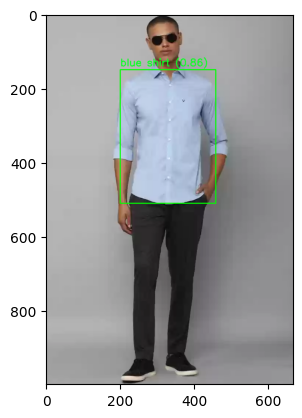


0: 640x448 1 black shirt, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


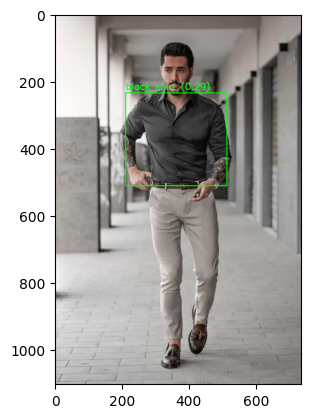


0: 640x544 1 blue shirt, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


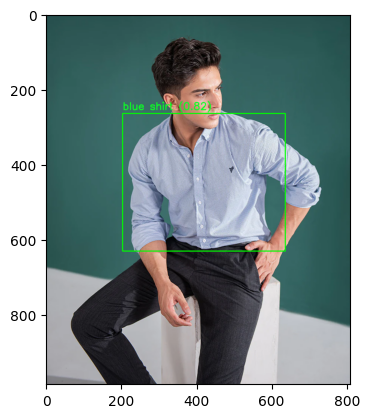


0: 640x640 1 black shirt, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


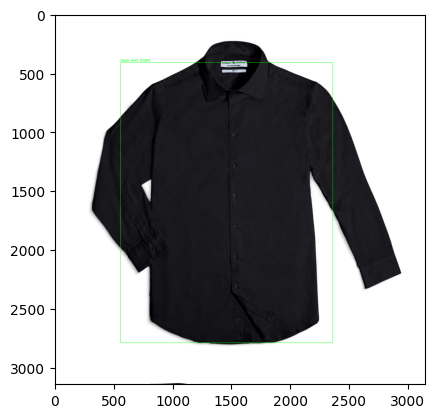


0: 640x640 1 blue shirt, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


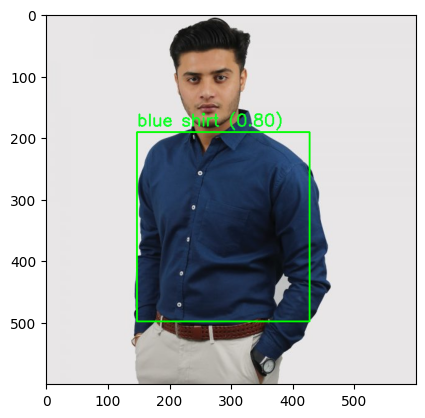

In [21]:
for i in imgaes_:
    test_image_path = i # Path to a test image
    detect_shirt_color(test_image_path, model_path)
    